In [1]:
import json 
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import pandas  as pd
import uproot
import numpy as np
import awkward as ak

# Service functions

#### Fonctions are modified to convert into one .json to SPE and one .json to acceptance

In [2]:
#We create here json files for SPE and acceptance based on the pdf_per_channel.npy and x_data_per_channel.npy files provided by @Pietro 22/12/2023

def SPE_to_json(x_data,y_data,x_name,y_name):
    x=np.load(x_data)
    y=np.load(y_data)
    json_dict= {'pmtID':np.arange(2000,2120).tolist(), x_name:x.tolist(),y_name:y.tolist()}
    with open("SPE_SR1_test_fuse.json",'w') as fi:
        json.dump(json_dict,fi)
    return 0

def acc_to_json(x,x_name):
    json_dict= {'pmtID':np.arange(2000,2120).tolist(), x_name:x.tolist()}
    with open("acceptance_SR1_test_fuse.json",'w') as fi:
        json.dump(json_dict,fi)
    return 0

#---------------------------------------------------------------
# SPE acceptance per PMT (SR0 values) #consider these just as a placeholder (SR1 values need to be calculated!)
spe_acc=np.array([91.2,91.1,92.9,89.8,92.7,94.8,93.0,90.6,90.0,89.9,89.0,84.2,89.0,93.7,92.3,91.1,91.8,91.1,92.7,92.4,86.7,93.8,93.7,92.7,92.9,94.1,92.3,84.5,89.6,91.9,86.5,91.5,92.6,89.5,92.5,90.1,92.9,92.8,88.0,91.3,92.5,88.2,95.0,94.2,90.8,88.0,92.5,91.3,89.4,93.4,91.7,92.2,93.0,91.0,83.5,87.9,88.3,90.1,91.2,90.6,92.5,92.3,93.2,89.4,90.9,88.0,92.6,91.4,93.2,92.3,86.9,93.8,92.2,93.6,92.1,91.4,93.0,92.0,93.6,91.4,86.6,94.7,93.7,93.2,91.3,92.3,94.7,91.2,94.4,93.6,91.4,94.9,89.4,91.5,90.7,92.2,91.4,91.5,93.1,91.9,87.5,92.2,92.1,90.1,93.0,93.3,89.2,88.7,92.0,94.2,88.9,90.3,92.3,87.6,91.0,89.8,91.9,91.6,92.2,93.9])*10**-2



In [3]:
#---------------------------------------------------------------
# Retrieving PMT QE
def _init_quantum_efficiency():
    """Loads and returns channel specific quantum efficiency values for
    neutron-veto PMTs. Returns a dictionary containing interpolated 
    QE for each channel
    """
    with open('nveto_pmt_qe.json', 'r') as f:
    # Load the contents of the file as a Python object
        nv_pmt_qe = json.load(f)
    res = {}

    wavelength = nv_pmt_qe['nv_pmt_qe_wavelength']
 
    for channel, qe in nv_pmt_qe['nv_pmt_qe'].items():
        res[channel] = interp1d(wavelength,
                                np.array(qe)/100, # QE-values in file are in percent...
                                bounds_error=False,
                                fill_value=0
                               )
    return res

#---------------------------------------------------------------
# We modify to original function to be used to get SPE and acceptances
def reading_aux_files(SPE_file,acc_file):
    with open(SPE_file,'r') as f:
        SPE = json.loads(f.read())
    x,y = SPE['charge'],SPE['SPE_values']
    with open(acc_file,'r') as f:
        acceptance = json.loads(f.read())
    acc= acceptance['acceptance']
    return x, y,acc

x_interp, pdf_per_channel, spe_acc = reading_aux_files('SPE_SR1_test_fuse.json','acceptance_SR0_test_fuse.json')


In [4]:
#---------------------------------------------------------------
# Sampling charge from SPE spectra
# old code; reading and drawing from CDFs

'''
def reading_cdf(data="cdf_sampling.npy"):
    y_cdf=np.load(data,allow_pickle=True)
    return y_cdf

y_cdfs=reading_cdf(data="cdf_sampling.npy")
# Indice -> Canale/PMT




def random_sampling_pdf(cdf,size=1):
    """
    Random sampling based on custom PDF
    x0   : x lower bound = 0
    x1   : x upper bound = 3
    pdf  : custom function normalized to 1
    size : number of events to generate
    """
    xi=np.arange(-100.,3,0.01)
    samples=np.zeros(size)
    for i in range(0,size):
        values = np.random.rand()
        value_bins = np.searchsorted(cdf, values)
        sample=xi[value_bins]
        samples[i]=sample    
    return samples
'''

"""
def _draw_charge(pmts, n_draws, cdfs):
    min_ch = 2000
    max_ch = 2120
    n_pmts = max_ch-min_ch+1
    res = np.zeros((n_pmts, np.max(n_draws)), np.float32)

    for ch, n_hits in zip(pmts, n_draws):
        cdf = cdfs[ch-min_ch]
        res[ch-min_ch][:n_hits] = random_sampling_pdf(cdf, n_hits)
    return res
"""

'\ndef _draw_charge(pmts, n_draws, cdfs):\n    min_ch = 2000\n    max_ch = 2120\n    n_pmts = max_ch-min_ch+1\n    res = np.zeros((n_pmts, np.max(n_draws)), np.float32)\n\n    for ch, n_hits in zip(pmts, n_draws):\n        cdf = cdfs[ch-min_ch]\n        res[ch-min_ch][:n_hits] = random_sampling_pdf(cdf, n_hits)\n    return res\n'

In [5]:
#---------------------------------------------------------------
# Sampling charge from SPE spectra

def _get_charge(pmthits, spe_pdfs,x_data):
    """Generates charge for each PMT hit. 
    :param pmthits: akward array containing the field "pmthitID"
    :param spe_pdfs: SPE pdfs
    """
    offsets = ak.num(pmthits['pmthitTime'])

    pmthitids = ak.ravel(pmthits['pmthitID'])
    pmts, n_hits = np.unique(pmthitids, return_counts=True)
    charge = _draw_charge(pmts, n_hits, spe_pdfs,x_data)#cdfs)
    pmtcharge = _map_charge(pmthitids, charge)

    pmthits['pmthitCharge'] = ak.unflatten(pmtcharge, offsets)
    return pmthits



#Nuovo: con pdf invece di cdf
def _draw_charge(pmts, n_draws, spe_pdfs,x_data):#x_data is the type of the output of reading_pdf ' x_interp'??
    n_pmts = 120
    res = np.zeros((n_pmts,  
                    np.max(n_draws)), np.float32)

    for ch, n_hits in zip(pmts, n_draws):
        
        spe_pdf_channel = spe_pdfs[ch-2000]
        x_data_channel = x_data[ch-2000]
        res[ch-2000][:n_hits] = np.random.choice(x_data_channel, 
                                           n_hits,
                                           p=spe_pdf_channel
         )
    return res


def _map_charge(pmthitids, charge):
    """Function which maps drawn charge for each PMT into the correct 
    order.
    """
    indicies = np.zeros(120, np.int64)
    res = np.zeros(len(pmthitids), np.float32)
    for ind, ch in enumerate(pmthitids):
        ch -= 2000
        _charge_in_hit = charge[ch][indicies[ch]] 
        if _charge_in_hit >=  0:
            res[ind] = _charge_in_hit
        indicies[ch] += 1
    return res

# Remarqs for stack_truth, _stack_truth and get_mc_truth functions:
- Where is defined the typical delta time between photons arriving in the same channel ( typical values should be around 8 ns, i.e. 4 samples)
- Where the primaries arrays from G4 like 'e_pri' or save_flag saved in the _stack_truth ? Is there a way to recover this information after building events?
-  I don't see what this function select close hitlets this functions seems to be redondant with stack_hitlets and _stacked hitlets and there are not used, what is their porpuse? There are obsolete

In [6]:
def stack_truth( truth):
    """Funciton which stacks delta pulse hitlets if they occure in the 
    same channel at the same time.
    """
    res = np.zeros(len(truth), dtype=truth.dtype)
    return _stack_truth(truth, res)

def _stack_truth(truth, res):
    offset = -1
    current_time = -1
    current_channel = -1
    for hit in truth:
        _is_same_delta_hit = hit['time'] == current_time and hit['channel'] == current_channel
        if _is_same_delta_hit:
            continue
        else:
            offset += 1
            res[offset]['time'] = hit['time']
            res[offset]['channel'] = hit['channel']
            res[offset]['save_flag'] = hit['save_flag']
            res[offset]['event_starts'] = hit['event_starts']
            res[offset]['e_pri'] = hit['e_pri']
            current_time = hit['time']
            current_channel = hit['channel']
    return res[:(offset+1)]

#This is a function that get primary parameters from G4, or just the pmthitTimes original hitlets????
def get_mc_truth( pmthits, hitlets):
        """Function which can be replaced by the user to store custom
        MC truth information for each hitlet. Takes awkward array 
        containing simulation information of each and the resulting 
        hitlet array.
        """
        return np.zeros(0, dtype=strax.time_fields + ['channel', np.int16])

# Remarqs for stack_hitlets, _stack_hitlets functions(same above) and convert_to_hitlets , convert_to_events:
- Where is defined the typical delta time between photons arriving in the same channel ( typical values should be around 8 ns, i.e. 4 samples)
- Where the primaries arrays from G4 like 'e_pri' or save_flag saved in the _stack_truth ? Is there a way to recover this information after building events?
- Why don't use instead of convert_to_events, just the cutax plugin as any other parameter is recovered...?

In [7]:
#---------------------------------------------------------------
# Creating straxen hitlets and events

import strax
def pseudo_hitlet_dtype():
    dtype = []
    dtype += strax.time_dt_fields
    dtype += [(('Psuedo hitlet area', 'area'), np.float32),
              (('Psuedo hitlet channel', 'channel'), np.int16)
             ]
    return dtype

def stack_hitlets(pseudo_hitlets):
    """Funciton which stacks delta pulse hitlets if they occure in the 
    same channel at the same time.
    """
    res = np.zeros(len(pseudo_hitlets), dtype=pseudo_hitlet_dtype())
    res['length'] = 1
    res['dt'] = 1
    return _stack_hitlets(pseudo_hitlets, res)

def _stack_hitlets(pseudo_hitlets, res):
    offset = -1
    current_time = -1
    current_channel = -1
    for hit in pseudo_hitlets:
        _is_same_delta_hit = hit['time'] == current_time and hit['channel'] == current_channel
        if _is_same_delta_hit:
            res[offset]['area'] += hit['area']
        else:
            offset += 1
            res[offset]['time'] = hit['time']
            res[offset]['channel'] = hit['channel']
            res[offset]['area'] = hit['area']
            current_time = hit['time']
            current_channel = hit['channel']
    return res[:(offset+1)]   

def convert_to_hitlets(
                       pmthits, 
                       source_rate=156,
                       max_time=int(3600*24*7),
                      ):
    """Function which converts GEANT4 output into pseudo hitlets. To 
    allow for pile-up draw event time stamps from a uniform distribution 
    mimicing the source rate.
    :param pmthits: awkward array storing information about the PMT hits.
    :param source_rate: Rate of the AmBe source in n/s.
    :param max_time: Maximum time allowed for events. Currently it is 
        set to one week to account for longer lived isotopes during 
        calibration.
    :returns: pseudo hitlets, mc_truth_extra_information
    """
    n_events = len(pmthits['pmthitTime'])
    offsets = ak.num(pmthits['pmthitTime'])
    event_times = np.random.uniform(0, n_events/source_rate, n_events)
    event_times *=10**9
    event_times = event_times.astype(np.int64) 
    # Add some unix time (20220526 19:44= otherwise sorting does not 
    # work
    event_times += np.int64(1653587233*10**9 )
    pmthits['event_start_times'] = event_times
    hit_times = pmthits['pmthitTime']*10**9 


    hit_times = ak.to_numpy(ak.ravel(hit_times)).astype(np.int64)
    event_times = np.repeat(event_times, offsets)
    hit_times += event_times

    res = np.zeros(len(hit_times), dtype=pseudo_hitlet_dtype())
    res['time'] = hit_times
    res['length'] = 1
    res['dt'] = 1
    res['area'] = ak.to_numpy(ak.ravel(pmthits['pmthitCharge']))
    res['channel'] = ak.to_numpy(ak.ravel(pmthits['pmthitID']))

    #mc_truth = get_mc_truth(pmthits, res)


    #Cut all hits which are more delayed than max time after the 
    # last event:
    # TODO: This is not 100 % correct as we need to do this actually
    # for ecah individual event....
    mask = (res['time'] - event_times.max())/10**9 < max_time
    res = np.sort(res[mask], order=('time', 'channel'))
    print(len(res))
    res = stack_hitlets(res)
    print(len(res))
    """
    if len(mc_truth):
        mc_truth = np.sort(mc_truth[mask], order=('time', 'channel'))
        mc_truth = stack_truth(mc_truth) """
    return res


import cutax
def convert_to_events(pseudo_hitlets):#WHY DON'T USE JUST CUTAX PLUGIN?????

    st_pseudo = cutax.contexts.xenonnt_online()
    p_events = st_pseudo.get_single_plugin('0', 'events_nv')
    # Events are only sorted by time within each file! 
    # Multiple files overlap in time!
    pseudo_events = []
    pseudo_event_positions = []
    pseudo_center_time_cut = []
    last_time_seen = None
    _pseudo_hitlets=pseudo_hitlets
    if last_time_seen:
        time_offset = last_time_seen - _pseudo_hitlets['time'].min()
        _pseudo_hitlets['time'] += time_offset + 2000
    
    last_time_seen = _pseudo_hitlets['time'].max()
    _pseudo_events = p_events.compute(_pseudo_hitlets, 0, _pseudo_hitlets['time'].max()+10)
    pseudo_events.append(_pseudo_events)

    pseudo_events = np.concatenate(pseudo_events)
    return pseudo_events

# Running example

# Remarqs: 
- Comment in english could help to understand how the set of functions are used, because this replace the main general function that takes root file argument.
- Missing functions 'cut_nveto_data' and 'convert_energy_to_wavelength' (the last one is replaced by mine to try to run the code)
- Some lines and elements are replaced in l.26

In [9]:
np.random.seed(42)

quantum_efficiency = _init_quantum_efficiency()

data=[]
ce = 0.75 # value from SR0 AmBe data-MC matching
print("Collection_Efficiency:",ce)

#Leggo i file root (output G4) e li appendo ad un singolo array
for i in range(0,50):
    try:
        file_root = '/project2/lgrandi/layos/output_n_Veto_neutron_AmBe_'+str(i)+'.root'
        #print("Opening File :",file_root)
        root_file = uproot.open(file_root)
        root_data = root_file['events'].arrays(['eventid', 'pmthitTime', 'pmthitEnergy', 'pmthitID'])
        data.append(root_data)
    except:
        continue
    
# trasformo data in awkward 
pmthits = ak.concatenate(data)
#Taglio PMT nVeto


#cut_nveto_data(pmthits)FUNCTION MISSING his doing some cuts in the PMTS??? that's why event area is a little shifted from the 20 pe peak of nCapture????
# Conversione Energia in lambda
#--------------------------------

#convert_energy_to_wavelength(pmthits)FUNCTION MISSING REPLACED AND ALSO MISSING LINE!
import scipy.constants as const
def energytowavelenght(E):
    Joules_to_eV=1.602*1e-19
    return 1e9*const.h*const.c/(E*Joules_to_eV)
pmthits['pmthitWavelength']=energytowavelenght(pmthits['pmthitEnergy'])

n_photons_wo_qe = ak.sum(ak.num(pmthits['pmthitTime'], axis=1))
n_events_wo_qe = len(pmthits)
#Prima di applicare la QE ho :
print(f'Number of events w/o QE: {n_events_wo_qe}')
print(f'Number of photons w/o QE: {n_photons_wo_qe}')

#QE and CE Manipulation (ma anche Acceptance) 
# Appiattisco l'array e applico i tagli (per velocizzare). Dopo uso offset per ricostruire la struttura originaria.
offsets = ak.num(pmthits['pmthitWavelength'])
pmthitchannel = ak.ravel(pmthits['pmthitID'])
pmthitwavelengths = ak.ravel(pmthits['pmthitWavelength'])
buffer = np.zeros(len(pmthitwavelengths), np.int16)

for ch in range(2000, 2120):
    mask = pmthitchannel == ch
    qe = quantum_efficiency[str(ch)](pmthitwavelengths[mask])
    p_detected = np.random.binomial(1, qe*ce*spe_acc[ch-2000])# Acceptance is applied here, this mean cutting a trivial percentage of the pes, not be more correct to cut only (1-acc)% of lowest charges 
    buffer[mask] = p_detected
    
#Buffer -> detection probability 0-1
pmthits['pmthitCharge'] = ak.unflatten(buffer, offsets)
_photons_detected = pmthits['pmthitCharge'] == 1
#Tolgo gli hit che non sono stati rivelati
pmthits["pmthitCharge"]=pmthits["pmthitCharge"][_photons_detected]
pmthits["pmthitWavelength"]=pmthits["pmthitWavelength"][_photons_detected]
pmthits["pmthitID"]=pmthits["pmthitID"][_photons_detected]
pmthits["pmthitTime"]=pmthits["pmthitTime"][_photons_detected]

n_photons_w_qe = ak.sum(ak.num(pmthits['pmthitTime'], axis=1))  #Calcolo il numero di hits sopravvissuti (numero di entries per ogni riga, sommati)
n_events_w_qe = len(pmthits) #Calcolo il numero di eventi (numero di righe)

print(f'Number of events w/ QE: {n_events_w_qe}')
print(f'Number of photons w/ QE: {n_photons_w_qe}')

#Campionamento della carica
#Charge sampling.
#pmthits = _get_charge(pmthits,y_cdfs) 
pmthits = _get_charge(pmthits,pdf_per_channel,x_interp)


n_photons_recorded = ak.sum(ak.num(pmthits['pmthitTime'][pmthits['pmthitCharge'] > 0], axis=1))
n_events_recorded = len(pmthits)
print(f'Number of events recorded: {n_events_recorded}')
print(f'Number of photons recorded: {n_photons_recorded}') 
# Carica a 0 registrata in alcuni hits.

#*----------------Creo Hitlets e Events --------------*
hitlets = convert_to_hitlets(pmthits)
events = convert_to_events(hitlets)
np.save('events_Andrea_.npy', events)
np.save('hitlets_Andrea.npy', hitlets)


Collection_Efficiency: 0.75
Number of events w/o QE: 76000
Number of photons w/o QE: 10789824
Number of events w/ QE: 76000
Number of photons w/ QE: 1653098
Number of events recorded: 76000
Number of photons recorded: 1652920
1653026
1616321
You specified _auto_append_rucio_local=True and you are not on dali compute nodes,so we will add the following rucio local path:  /project/lgrandi/rucio/


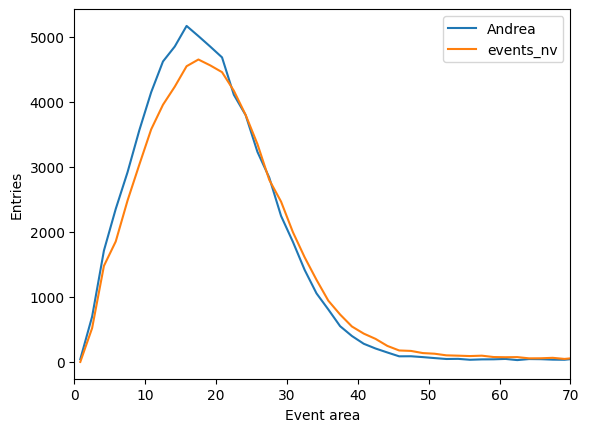

In [16]:
events_nv= np.load('events_nv_th_test.npy')
y,x = np.histogram(events['area'], range=[0,100], bins=60)
x_c=(x[:-1] + x[1:]) / 2
y_n,x_n = np.histogram(events_nv['area'], range=[0,100], bins=60)
x_c_n=(x[:-1] + x[1:]) / 2
plt.plot(x_c,y, label='Andrea')
plt.plot(x_c_n,y_n, label='events_nv')
plt.ylabel('Entries')
plt.xlabel('Event area')
plt.legend()
plt.xlim(0,70)
plt.show()

In [ ]:
#Spectrum seems a little bit shifted from the expected nCapture peak